In [1]:
# Установка зависимостей и подготовка окружения
# ============================================
# Эта ячейка устанавливает необходимые библиотеки: Kaggle API, Detectron2, OpenCV и т.д.

!pip install -q kaggle
!pip install -q git+https://github.com/facebookresearch/detectron2.git
!pip install -q opencv-python-headless
!pip install -q pycocotools

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.8 MB/s eta 0:00:00


In [2]:
# Импорт необходимых модулей
import os
import zipfile
import json
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode

In [3]:
# Создадим рабочие директории
BASE_DIR = '/content/NuInsSeg'
IMAGES_DIR = os.path.join(BASE_DIR, 'all_images')  # сюда соберем все изображения
MASKS_DIR = os.path.join(BASE_DIR, 'all_masks')   # сюда соберем все метки
ANNOTATIONS_DIR = os.path.join(BASE_DIR, 'annotations')
OUTPUT_DIR = '/content/output'

os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(MASKS_DIR, exist_ok=True)
os.makedirs(ANNOTATIONS_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
# -----------------------------------------------------------------------------------------------------------------------
# Загрузка и распаковка датасета с Kaggle
# --------------------------------------------------------------------------------------
# Предполагается, что у вас загружен файл kaggle.json с токеном API, который нужно поместить в /root/.kaggle/
# В Colab сначала загружаем его вручную через интерфейс, затем выполняем:

# Создадим папку для kaggle.json и переместим его
!mkdir -p ~/.kaggle

In [5]:
# После этого вручную загружаем kaggle.json через интерфейс Colab в ~/.kaggle/kaggle.json
# Установим права доступа
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Скачаем датасет NuInsSeg с Kaggle
!kaggle datasets download -d ipateam/nuinsseg -p /content/NuInsSeg

# Распакуем архив
with zipfile.ZipFile('/content/NuInsSeg/nuinsseg.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/NuInsSeg')

# После распаковки структура должна быть примерно такой:
# /content/NuInsSeg/images/ и /content/NuInsSeg/masks/ (внутри — подкаталоги train и val)

Dataset URL: https://www.kaggle.com/datasets/ipateam/nuinsseg
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 1.49G/1.52G [00:13<00:00, 215MB/s]
100% 1.52G/1.52G [00:13<00:00, 124MB/s]


Processing test: 100%|██████████| 20/20 [00:02<00:00,  7.90it/s]


[06/09 20:24:11 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 132MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[06/09 20:24:13 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/09 20:24:24 d2.utils.events]:  eta: 0:02:37  iter: 19  total_loss: 5.427  loss_cls: 0.7252  loss_box_reg: 0.531  loss_mask: 0.6939  loss_rpn_cls: 3.231  loss_rpn_loc: 0.2255    time: 0.3309  last_time: 0.3687  data_time: 0.0300  last_data_time: 0.0156   lr: 9.7405e-06  max_mem: 1817M
[06/09 20:24:36 d2.utils.events]:  eta: 0:02:30  iter: 39  total_loss: 2.633  loss_cls: 0.6693  loss_box_reg: 0.6594  loss_mask: 0.6812  loss_rpn_cls: 0.4703  loss_rpn_loc: 0.1594    time: 0.3305  last_time: 0.3166  data_time: 0.0095  last_data_time: 0.0142   lr: 1.9731e-05  max_mem: 1817M
[06/09 20:24:43 d2.utils.events]:  eta: 0:02:24  iter: 59  total_loss: 2.339  loss_cls: 0.5768  loss_box_reg: 0.698  loss_mask: 0.6517  loss_rpn_cls: 0.2312  loss_rpn_loc: 0.1592    time: 0.3338  last_time: 0.3170  data_time: 0.0106  last_data_time: 0.0067   lr: 2.972e-05  max_mem: 1817M
[06/09 20:24:50 d2.utils.events]:  eta: 0:02:17  iter: 79  total_loss: 2.206  loss_cls: 0.5102  loss_box_reg: 0.7156  loss_mask: 0.

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[06/09 20:36:26 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output_initial/model_final.pth ...


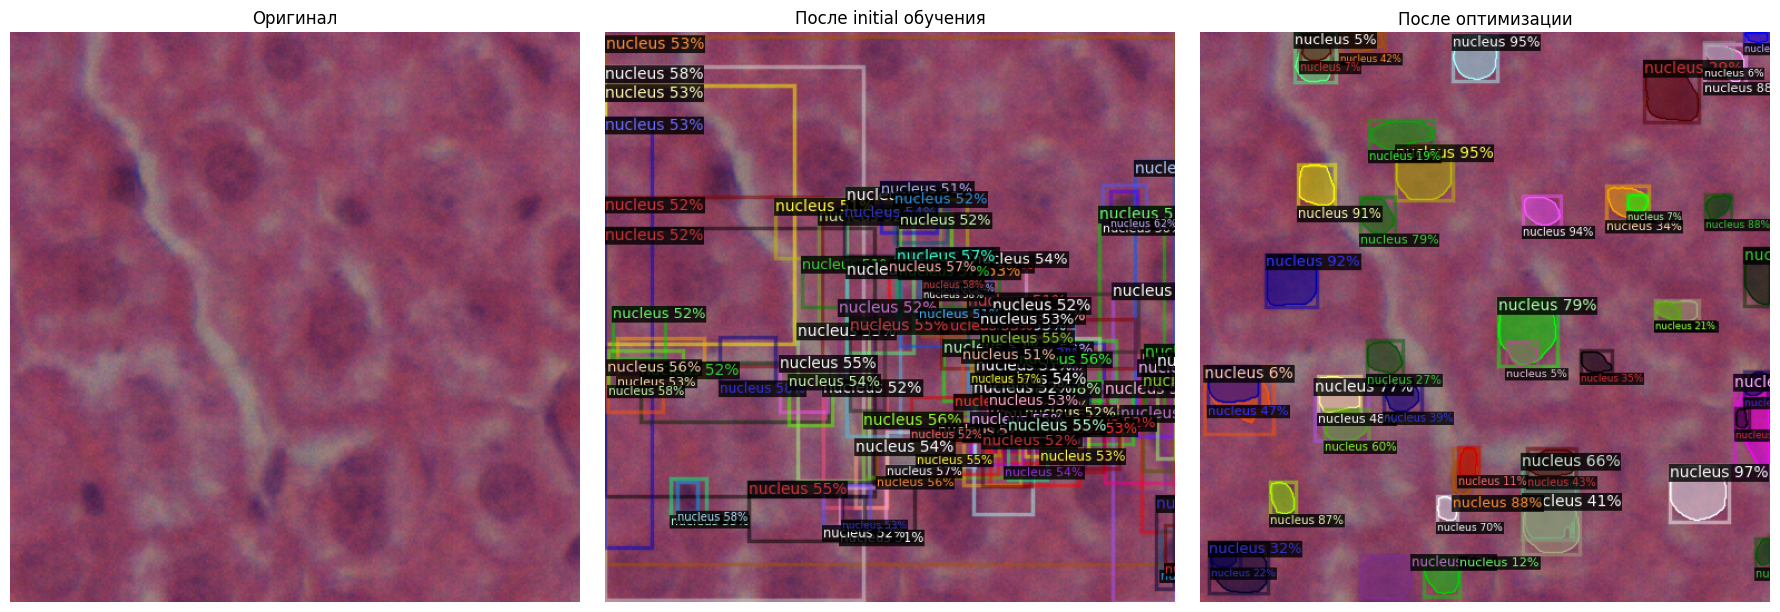

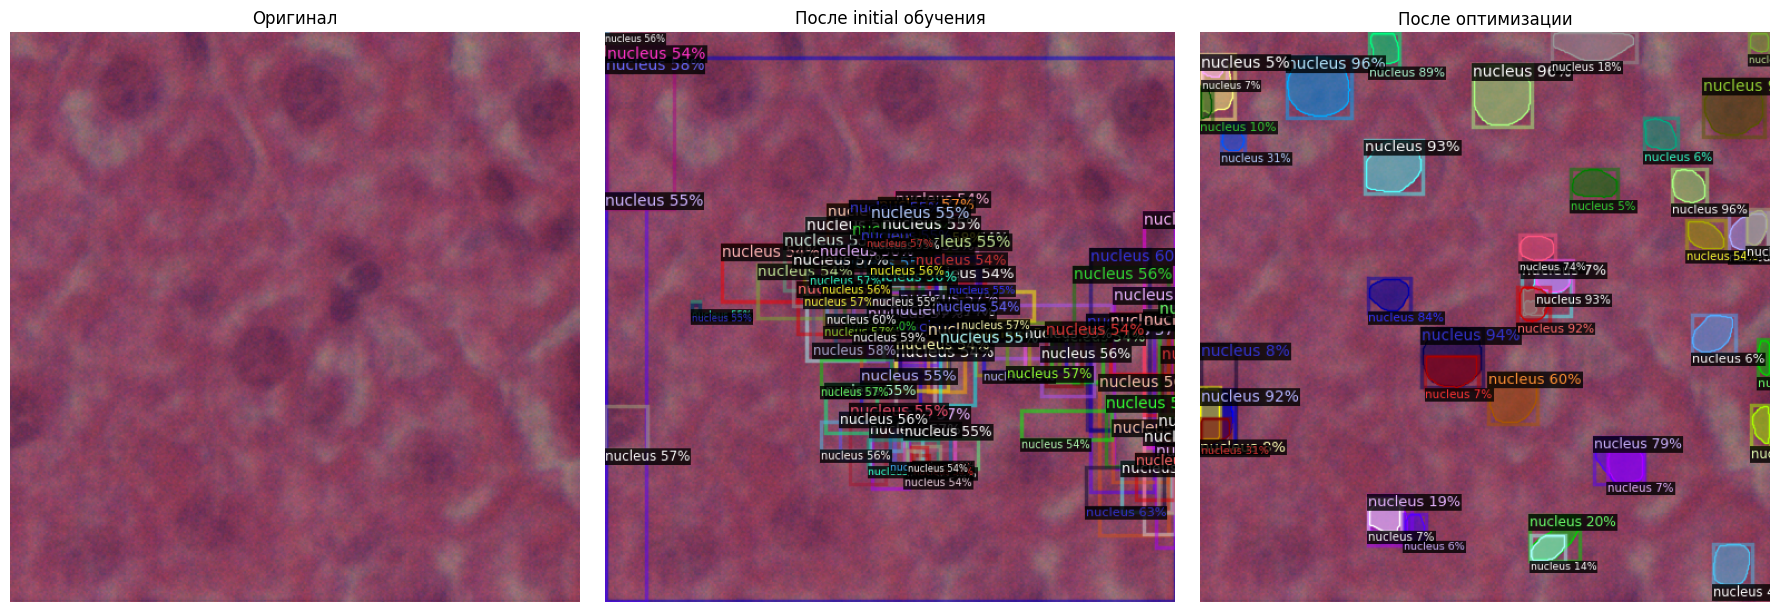

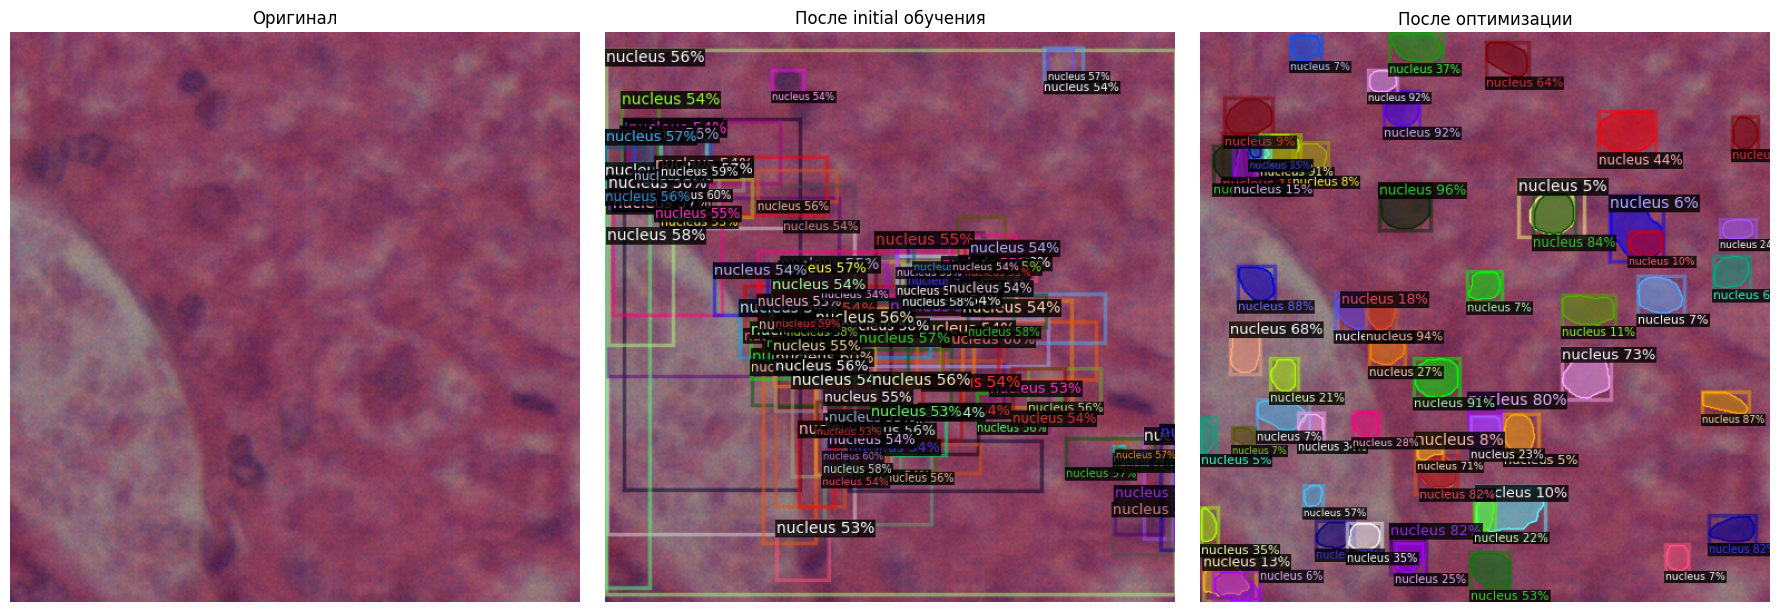

In [7]:
import os
import random
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
from detectron2.structures import BoxMode
from pycocotools import mask as mask_utils
from skimage import measure
import json

# 1. Функция для подготовки COCO JSON аналогично предыдущему примеру
# ---------------------------------------------------------------

def get_nuinsseg_dicts(base_dir, organs, output_dir, splits=(0.7, 0.15, 0.15)):
    dataset_dicts = {"train": [], "val": [], "test": []}
    image_id = 0
    coco_output = {"train": {"images": [], "annotations": [], "categories": [{"id": 0, "name": "nucleus"}]},
                   "val": {"images": [], "annotations": [], "categories": [{"id": 0, "name": "nucleus"}]},
                   "test": {"images": [], "annotations": [], "categories": [{"id": 0, "name": "nucleus"}]}}

    all_pairs = []
    for organ in organs:
        img_dir = os.path.join(base_dir, organ, "tissue images")
        mask_dir = os.path.join(base_dir, organ, "label masks modify")
        img_paths = sorted(glob(os.path.join(img_dir, "*.png")))
        for img_path in img_paths:
            mask_filename = os.path.splitext(os.path.basename(img_path))[0] + ".tif"
            mask_path = os.path.join(mask_dir, mask_filename)
            if os.path.exists(mask_path):
                all_pairs.append((img_path, mask_path))
    random.shuffle(all_pairs)
    n = len(all_pairs)
    train_split = int(n * splits[0])
    val_split = int(n * (splits[0] + splits[1]))
    split_map = {"train": all_pairs[:train_split], "val": all_pairs[train_split:val_split], "test": all_pairs[val_split:]}

    for split, pairs in split_map.items():
        for img_path, mask_path in tqdm(pairs, desc=f"Processing {split}"):
            height, width = cv2.imread(img_path).shape[:2]
            record = {
                "file_name": img_path,
                "image_id": image_id,
                "height": height,
                "width": width
            }
            mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            objs = []
            for region_id in np.unique(mask):
                if region_id == 0:
                    continue
                binary_mask = (mask == region_id).astype(np.uint8)
                contours = measure.find_contours(binary_mask, 0.5)
                segmentation = []
                for contour in contours:
                    contour = np.flip(contour, axis=1)
                    segmentation.append(contour.ravel().tolist())
                if not segmentation:
                    continue
                rle = mask_utils.encode(np.asfortranarray(binary_mask))
                area = mask_utils.area(rle)
                bbox = mask_utils.toBbox(rle).tolist()
                objs.append({
                    "bbox": bbox,
                    "bbox_mode": BoxMode.XYWH_ABS,
                    "segmentation": segmentation,
                    "category_id": 0,
                    "iscrowd": 0
                })
                coco_output[split]["annotations"].append({
                    "id": len(coco_output[split]["annotations"]),
                    "image_id": image_id,
                    "category_id": 0,
                    "segmentation": segmentation,
                    "area": float(area),
                    "bbox": bbox,
                    "iscrowd": 0
                })
            record["annotations"] = objs
            dataset_dicts[split].append(record)
            coco_output[split]["images"].append({
                "id": image_id,
                "file_name": img_path,
                "height": height,
                "width": width
            })
            image_id += 1
    os.makedirs(output_dir, exist_ok=True)
    for split in ["train", "val", "test"]:
        path = os.path.join(output_dir, f"instances_{split}.json")
        with open(path, "w") as f:
            f.write('{' + '\n')
            f.write('"images": ')
            json.dump(coco_output[split]["images"], f)
            f.write(',\n"annotations": [\n')
            for i, ann in enumerate(coco_output[split]["annotations"]):
                json.dump(ann, f)
                if i != len(coco_output[split]["annotations"]) - 1:
                    f.write(',\n')
                else:
                    f.write('\n')
            f.write('],\n"categories": ')
            json.dump(coco_output[split]["categories"], f)
            f.write('\n}')
    return dataset_dicts

# ========================================================
# 2. Подготовка датасета и регистрация в Detectron2
# ========================================================
from detectron2.data import DatasetCatalog, MetadataCatalog

base_dir = "/content/NuInsSeg"
output_dir = "/content/annotations"
organs = ["human breast", "human colon", "human kidney", "human liver", "mouse breast", "mouse colon", "mouse kidney", "mouse liver"]

nuinsseg_dicts = get_nuinsseg_dicts(base_dir, organs, output_dir)
for split in ["train", "val"]:
    DatasetCatalog.register(f"nuinsseg_{split}", lambda split=split: nuinsseg_dicts[split])
    MetadataCatalog.get(f"nuinsseg_{split}").set(thing_classes=["nucleus"])
nuinsseg_metadata = MetadataCatalog.get("nuinsseg_train")

# ========================================================
# 3. Первичное обучение модели (до оптимизации)
# ========================================================
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

# Конфиг для первоначального обучения
cfg_initial = get_cfg()
cfg_initial.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg_initial.DATASETS.TRAIN = ("nuinsseg_train",)
cfg_initial.DATASETS.TEST = ("nuinsseg_val",)
cfg_initial.DATALOADER.NUM_WORKERS = 2
cfg_initial.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg_initial.SOLVER.IMS_PER_BATCH = 2
cfg_initial.SOLVER.BASE_LR = 0.00025
cfg_initial.SOLVER.MAX_ITER = 500  # небольшое число для демонстрации
cfg_initial.SOLVER.STEPS = []  # без снижения lr
cfg_initial.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg_initial.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg_initial.OUTPUT_DIR = "/content/output_initial"
os.makedirs(cfg_initial.OUTPUT_DIR, exist_ok=True)
trainer_initial = DefaultTrainer(cfg_initial)
trainer_initial.resume_or_load(resume=False)
trainer_initial.train()

# Сохраняем веса после первоначального обучения
initial_weights = os.path.join(cfg_initial.OUTPUT_DIR, "model_final.pth")

# ========================================================
# 4. Оптимизированное обучение модели (after tuning)
# ========================================================
cfg_opt = get_cfg()
cfg_opt.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg_opt.DATASETS.TRAIN = ("nuinsseg_train",)
cfg_opt.DATASETS.TEST = ("nuinsseg_val",)
cfg_opt.DATALOADER.NUM_WORKERS = 2
# Начинаем с весов initial для дообучения
cfg_opt.MODEL.WEIGHTS = initial_weights
cfg_opt.SOLVER.IMS_PER_BATCH = 2
# Снижаем LR и добавляем шаги снижения
cfg_opt.SOLVER.BASE_LR = 0.00005
cfg_opt.SOLVER.MAX_ITER = 1500
cfg_opt.SOLVER.STEPS = (1000, 1300)  # снижение LR на 1000 и 1300 итерациях
cfg_opt.SOLVER.GAMMA = 0.1
cfg_opt.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg_opt.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg_opt.OUTPUT_DIR = "/content/output_optimized"
os.makedirs(cfg_opt.OUTPUT_DIR, exist_ok=True)
trainer_opt = DefaultTrainer(cfg_opt)
trainer_opt.resume_or_load(resume=False)
trainer_opt.train()

# Сохраняем финальные веса оптимизированной модели
optimized_weights = os.path.join(cfg_opt.OUTPUT_DIR, "model_final.pth")

# ========================================================
# 5. Визуализация сравнения: оригинал, предсказание initial, предсказание optimized
# ========================================================
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
import matplotlib.pyplot as plt

# Создаём два предиктора: один с весами initial, другой - optimized
predictor_initial = DefaultPredictor(cfg_initial)
predictor_opt = DefaultPredictor(cfg_opt)

# Выбираем несколько примеров из val
sample_images = random.sample(nuinsseg_dicts["val"], 3)
for rec in sample_images:
    img_path = rec["file_name"]
    im = cv2.imread(img_path)

    # Предсказание до оптимизации
    outputs_initial = predictor_initial(im)["instances"].to("cpu")
    # Предсказание после оптимизации
    outputs_opt = predictor_opt(im)["instances"].to("cpu")

    # Визуализация
    vis_orig = im[:, :, ::-1].copy()  # RGB

    v_init = Visualizer(im[:, :, ::-1], metadata=nuinsseg_metadata, scale=1.0, instance_mode=ColorMode.SEGMENTATION)
    vis_init = v_init.draw_instance_predictions(outputs_initial).get_image()

    v_opt = Visualizer(im[:, :, ::-1], metadata=nuinsseg_metadata, scale=1.0, instance_mode=ColorMode.SEGMENTATION)
    vis_opt = v_opt.draw_instance_predictions(outputs_opt).get_image()

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(vis_orig)
    axes[0].set_title("Оригинал")
    axes[0].axis('off')

    axes[1].imshow(vis_init)
    axes[1].set_title("После initial обучения")
    axes[1].axis('off')

    axes[2].imshow(vis_opt)
    axes[2].set_title("После оптимизации")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator_init = COCOEvaluator("nuinsseg_val", cfg_initial, False, output_dir="/content/output/init_eval")
val_loader = build_detection_test_loader(cfg_initial, "nuinsseg_val")
print("📉 Evaluation: Initial model")
inference_on_dataset(predictor_initial.model, val_loader, evaluator_init)




WARNING [06/09 20:49:57 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[06/09 20:49:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/09 20:49:57 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/09 20:49:57 d2.data.common]: Serializing 19 elements to byte tensors and concatenating them all ...
[06/09 20:49:57 d2.data.common]: Serialized dataset takes 1.84 MiB
📉 Evaluation: Initial model
[06/09 20:49:57 d2.evaluation.evaluator]: Start inference on 19 batches
[06/09 20:49:59 d2.evaluation.evaluator]: Inference done 11/19. Dataloading: 0.0049 s/iter. Inference: 0.1129 s/iter. Eval: 0.0708 s/iter. Total: 0.1886 s/iter. ETA=0:00:01
[06/09 20:50:01 d2.evaluation.evaluator]: Total inference time: 0:00:02.425363 (0.173240 

OrderedDict([('bbox',
              {'AP': 1.4306916358099084,
               'AP50': 5.011472939992634,
               'AP75': 0.6660112020628406,
               'APs': 1.8298962757782316,
               'APm': 1.3123501975777436,
               'APl': nan}),
             ('segm',
              {'AP': 0.0,
               'AP50': 0.0,
               'AP75': 0.0,
               'APs': 0.0,
               'APm': 0.0,
               'APl': nan})])

In [15]:
evaluator_init = COCOEvaluator("nuinsseg_val", cfg_opt, False, output_dir="/content/output/init_eval")
val_loader = build_detection_test_loader(cfg_opt, "nuinsseg_val")
print("📈 Evaluation: Optimized model")
inference_on_dataset(predictor_opt.model, val_loader, evaluator_init)

WARNING [06/09 20:50:06 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[06/09 20:50:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/09 20:50:06 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/09 20:50:06 d2.data.common]: Serializing 19 elements to byte tensors and concatenating them all ...
[06/09 20:50:06 d2.data.common]: Serialized dataset takes 1.84 MiB
📈 Evaluation: Optimized model
[06/09 20:50:06 d2.evaluation.evaluator]: Start inference on 19 batches
[06/09 20:50:08 d2.evaluation.evaluator]: Inference done 11/19. Dataloading: 0.0013 s/iter. Inference: 0.0936 s/iter. Eval: 0.0275 s/iter. Total: 0.1224 s/iter. ETA=0:00:00
[06/09 20:50:09 d2.evaluation.evaluator]: Total inference time: 0:00:02.154116 (0.15386

OrderedDict([('bbox',
              {'AP': 36.56636228937607,
               'AP50': 79.9069403098667,
               'AP75': 28.30163073146896,
               'APs': 32.530233205125505,
               'APm': 44.31066148620721,
               'APl': nan}),
             ('segm',
              {'AP': 34.2025380649573,
               'AP50': 78.11593357817193,
               'AP75': 24.78251070291492,
               'APs': 28.318090605565672,
               'APm': 43.580163215640596,
               'APl': nan})])